Copier-coller de https://github.com/trancept/deep_learning_tests/blob/0069edb660b71775706c80f9cafb660c6d42324c/01-Binary_Classification_747_vs_A380.ipynb pourtant le résultat n'est pas le même du tout :-(

# Binary Classification of 747 vs A380
The goal is to classify a picture between two classes : an Boing 747 or an Airbus A380

There is a nice script to get images from Google : https://github.com/boxabirds/fastai-helpers/blob/master/training-data-generator.py, it's based on https://github.com/hardikvasa/google-images-download wich use ChromeDriver to automate the process.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
tmp_name='tmp_old'
PATH = "../../datasets/boeing_vs_airbus/"
!rm -r {PATH}{tmp_name}
#PATH = "../../datasets/A380_vs_A330/"

In [3]:
## Getting dataset
#!mkdir ../../datasets/boing_vs_airbus
#!pip install google_images_download
#!ls ../../datasets/
#!cd {PATH} && mkdir -p train/747 train/A380 test/747 test/A380  valid/747 valid/A380
#!cd {PATH}/747 && googleimagesdownload --keywords "Boing 747" --limit 1000 --chromedriver /usr/local/bin/chromedriver
#!cd {PATH}/A380 && googleimagesdownload --keywords "Airbus A380" --limit 1000 --chromedriver /usr/local/bin/chromedriver
## Getting models weights
#!cd ./fastai && wget http://files.fast.ai/models/weights.tgz && tar -xvzf weights.tgz
!ls {PATH}

models	tmp  train  valid


In [4]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="5"
print("Loading Fast.AI modules...")
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *




sz=299
#arch=resnet34 # F2 :  0.937
#arch=resnext50
arch=resnext101_64
bs=132

Setting CUDA devices...
Loading Fast.AI modules...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
print("CuDNN optimization is ", torch.backends.cudnn.enabled)

CuDNN optimization is  True


Data augmentation options : https://becominghuman.ai/data-augmentation-using-fastai-aefa88ca03f1

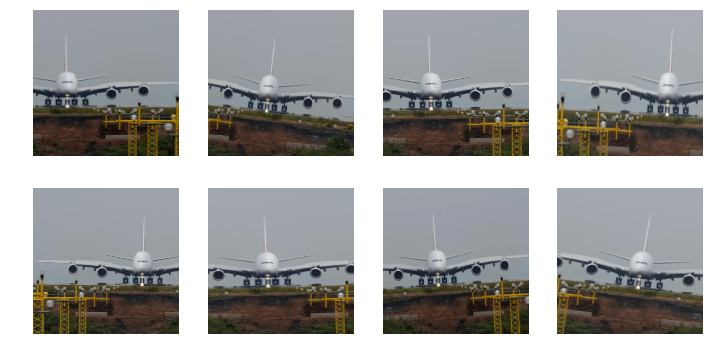

In [6]:

aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),
        RandomFlip(),
        RandomLighting(0.05, 0.05,tfm_y=TfmType.NO),
        RandomZoom(zoom_max=0.2),
        RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
# Taille de batch faible pour trouver le bon learning rate
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())

def get_augs():
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=2, num_workers=2)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(8)])
plots(ims, rows=2)

In [7]:
loadmodel=False
#loadmodel=True
if loadmodel==True:
    tfms = tfms_from_model(resnet34, 300, aug_tfms=aug_tfms, max_zoom=0.5)
    # On recharge les données avec une taille de batch plus importante pour aller plus vite
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    learn.precompute=False
    learn.ps=dropout # Drop-out plus faible pour les premières couches pour éviter de désapprendre des choses.
    learn.load("resnet34_151_300_weights")
    print("Model chargé")

In [8]:
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, tmp_name=tmp_name)
learn.unfreeze()
# resnet34 : acc 93.54%, F2 :  0.93, for learning_rate = 1e-3, dropout = [0.25,0.5], 
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 3],
#     [123, 300, 3],
#     [64, 600, 3],
#     [123, 300, 6],
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3],
#     [123, 400, 2]
# ]

# Resnext50 : 95.48%, F2 :  0.96, learning_rate = 1e-3, dropout = [0.25,0.5], 

# training_loop = [
#     [512, 64, 4],
#     [256, 128, 3],
#     [123, 300, 3],
#     [64, 600, 3],
#     [123, 300, 6],
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3],
#     [123, 400, 2]
# ]

# resnext101_64: 93.87 % F2 :  0.95, learning_rate = 1e-3, dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 3],
#     [123, 300, 3],
#     [64, 600, 3],
#     [123, 300, 6],
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3],
#     [123, 400, 2]
# ]




learning_rate = 1e-3
dropout = [0.25,0.5]
global_results = collections.OrderedDict([])

training_loop = [
    [512, 64, 4],
    [256, 128, 3],
    [123, 300, 3],
    [64, 600, 3],
    [123, 300, 6],
    [256, 128, 2],
    [123, 300, 2],
    [64, 600, 3],
    [123, 400, 6]
]
for bs, sz, cycle in training_loop:
    print("Hyperparameters : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", cycle, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    # On recharge les données avec une taille de batch plus importante pour aller plus vite
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    lr=np.array([learning_rate/10,learning_rate/5,learning_rate]) # Learning rate plus faible pour les premières couche, pour ré-apprendre un peu si necessaire
    learn.ps = dropout
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, cycle_len=1, cycle_mult=2, get_ep_vals=True)
    if len(global_results) > 0:
        #print(global_results)
        for k, v in ep_vals_s2s.items():
            global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)

Hyperparameters : Batch size= 512  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 4  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.682441   0.586617   0.683871  
    1      0.513397   0.428183   0.806452                    
    2      0.420765   0.397463   0.825806                    
    3      0.371326   0.275425   0.880645                    
    4      0.295254   0.295142   0.880645                    
    5      0.225241   0.240184   0.9                         
    6      0.195061   0.240288   0.893548                    
    7      0.251743   0.289053   0.887097                    
    8      0.201779   0.293465   0.896774                    
    9      0.172259   0.236558   0.906452                    
    10     0.15786    0.29542    0.887097                    
    11     0.123199   0.245347   0.909677                    
    12     0.157907   0.237888   0.916129                    
    13     0.132806   0.182214   0.922581                     
    14     0.113244   0.215083   0.909677                     

After  15  epochs, the 

epoch      trn_loss   val_loss   accuracy                    
    0      0.159501   0.262402   0.909677  
    1      0.126627   0.218949   0.916129                    
    2      0.139399   0.235301   0.903226                    
    3      0.123434   0.29488    0.896774                     
    4      0.087406   0.208684   0.929032                     
    5      0.093067   0.274288   0.909677                     
    6      0.076736   0.260509   0.912903                     

After  22  epochs, the accuracy is  91.29 %
Saving to  resnext101_64_22_128_acc91.29_weights
Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 3  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                     
    0      0.106265   0.153901   0.93871   
    1      0.119014   0.165726   0.932258                     
    2      0.113095   0.193517   0.929032                     
    3      0.09164    0.275306   0.9                          
    4      0.095001   0.187774   0.922581                     
    5      0.09034    0.133955   0.941935                     
    6      0.109616   0.153627   0.929032                     

After  29  epochs, the accuracy is  92.90 %
Saving to  resnext101_64_29_300_acc92.90_weights
Hyperparameters : Batch size= 64  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 3  Images sizes= 600


epoch      trn_loss   val_loss   accuracy                     
    0      0.092528   0.183352   0.912903  
    1      0.080748   0.225415   0.912903                     
    2      0.083962   0.168628   0.925806                     
    3      0.070855   0.16581    0.925806                     
    4      0.107428   0.145836   0.945161                     
    5      0.072107   0.153342   0.932258                     
    6      0.113472   0.154358   0.929032                     

After  36  epochs, the accuracy is  92.90 %
Saving to  resnext101_64_36_600_acc92.90_weights
Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 6  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                     
    0      0.077178   0.16045    0.929032  
    1      0.097601   0.229461   0.9                          
    2      0.085383   0.200996   0.909677                     
    3      0.094357   0.281141   0.887097                     
    4      0.124363   0.16087    0.941935                     
    5      0.074618   0.186622   0.922581                     
    6      0.06655    0.167116   0.929032                     
    7      0.108276   0.204885   0.916129                     
    8      0.115348   0.168491   0.932258                     
    9      0.0848     0.15747    0.935484                     
    10     0.093939   0.162721   0.93871                      
    11     0.075438   0.149856   0.941935                     
    12     0.061302   0.191489   0.919355                     
    13     0.091002   0.142088   0.945161                     
    14     0.073029   0.14726    0.945161                     
    15     

epoch      trn_loss   val_loss   accuracy                     
    0      0.036288   0.123492   0.954839  
    1      0.071303   0.131704   0.951613                     
    2      0.037975   0.120007   0.96129                      

After  102  epochs, the accuracy is  96.12 %
Saving to  resnext101_64_102_128_acc96.12_weights
Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 2  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                     
    0      0.065421   0.193585   0.929032  
    1      0.059596   0.160837   0.945161                     
    2      0.037155   0.130078   0.954839                     

After  105  epochs, the accuracy is  95.48 %
Saving to  resnext101_64_105_300_acc95.48_weights
Hyperparameters : Batch size= 64  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 3  Images sizes= 600


epoch      trn_loss   val_loss   accuracy                     
    0      0.05669    0.124003   0.96129   
    1      0.057841   0.122165   0.964516                     
    2      0.02945    0.118146   0.954839                     
    3      0.052098   0.133003   0.951613                     
    4      0.085217   0.109308   0.958065                     
    5      0.081667   0.112964   0.96129                      
    6      0.038828   0.134241   0.948387                     

After  112  epochs, the accuracy is  94.83 %
Saving to  resnext101_64_112_600_acc94.83_weights
Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 6  Images sizes= 400


epoch      trn_loss   val_loss   accuracy                     
    0      0.035642   0.11586    0.954839  
    1      0.037224   0.094679   0.954839                     
    2      0.046029   0.104785   0.954839                     
    3      0.031484   0.117532   0.954839                     
    4      0.040735   0.111197   0.951613                     
    5      0.037621   0.104951   0.958065                     
    6      0.037264   0.097736   0.96129                      
    7      0.098513   0.175217   0.935484                     
    8      0.040258   0.117616   0.954839                     
    9      0.054411   0.128925   0.948387                     
    10     0.033223   0.127559   0.954839                     
    11     0.040641   0.115321   0.948387                     
    12     0.038381   0.121921   0.951613                     
    13     0.032454   0.118065   0.958065                     
    14     0.077096   0.135349   0.948387                     
    15     

SGDR : Earlier we said 3 is the number of epochs, but it is actually *cycles*. So if cycle_len=2 , it will do 3 cycles where each cycle is 2 epochs (i.e. 6 epochs). Then why did it 7? It is because of cycle_mult :
    cycle_mult=2 : this multiplies the length of the cycle after each cycle (1 epoch + 2 epochs + 4 epochs = 7 epochs).

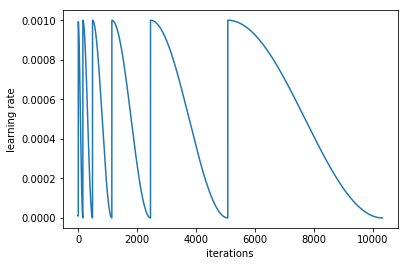

In [9]:
learn.sched.plot_lr()

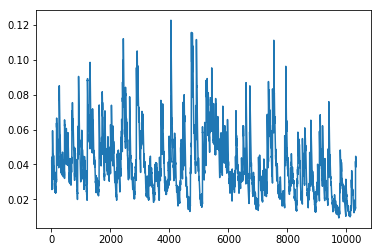

In [10]:
learn.sched.plot_loss()

In [11]:
# Il faudrait recalculer le LR optimal mais la taille de batch est trop grande, le graph reste vide.
#lrf=learn.lr_find()
#learn.sched.plot()
# ep_vals_s2s

In [12]:
len(learn.sched.losses)
#ep_vals_s2s.values()
print("Nombre d'epochs : ", len(global_results))

10332

Nombre d'epochs :  175


<Figure size 800x640 with 0 Axes>

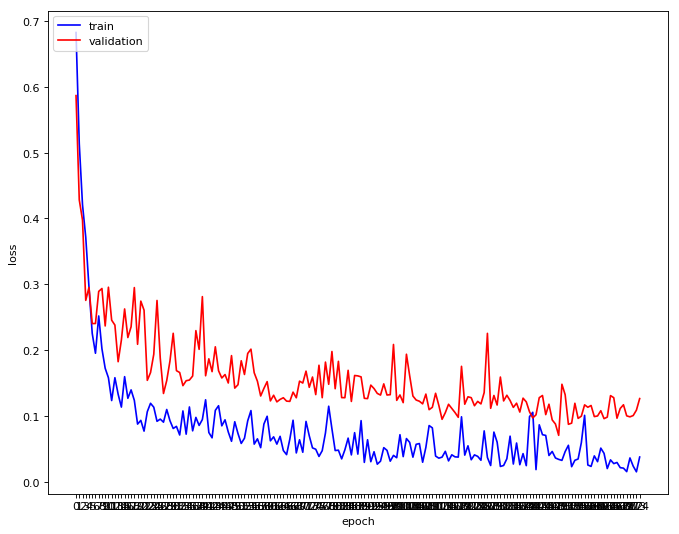

In [13]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = len(ep_vals)#ep_vals.keys()
    #plt.xticks(np.asarray(list(epochs)))
    plt.xticks((list(ep_vals)))
    #print((list(ep_vals)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    #print(trn_losses)
    val_losses = [item[1] for item in list(ep_vals.values())]
    #print(val_losses)
    plt.plot(list(ep_vals), trn_losses, c='b', label='train')
    plt.plot(list(ep_vals), val_losses, c='r', label='validation')
    plt.legend(loc='upper left')
plot_ep_vals(global_results)

# Prediction et visualisation

0.9612903225806452

[[154   1]
 [ 11 144]]


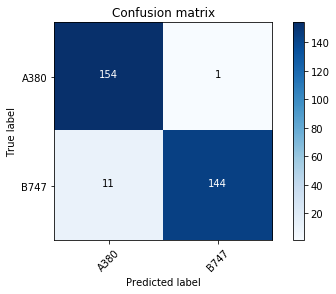

In [14]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

## Precision and Recall
Précision et rappel en français : https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel
_La précision est le nombre de documents pertinents retrouvés rapporté au nombre de documents total proposé par le moteur de recherche pour une requête donnée. _ Autrement dit quelle proportion d'identifications positives était effectivement correcte ?

_Le rappel est défini par le nombre de documents pertinents retrouvés au regard du nombre de documents pertinents que possède la base de données._ Autrement dit quelle proportion de résultats positifs réels a été identifiée correctement ?

In [15]:
# precission = VP / (VP + FP)
precision = cm[0][0]/(cm[0][1]+cm[0][0]);
print("Precision : ", precision)
# recall =  = VP / (VP + FN)
recall = cm[0][0]/(cm[1][0]+cm[0][0]);
print("recall : ", recall)
F1 = 2 * ((precision*recall)/(precision + recall))
print("F1 : ", F1)
F2 = 5 * ((precision*recall)/(4*precision + recall))
print("F2 : ", F2)

Precision :  0.9935483870967742
recall :  0.9333333333333333
F1 :  0.9625000000000001
F2 :  0.9447852760736197


(array([155.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 155.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

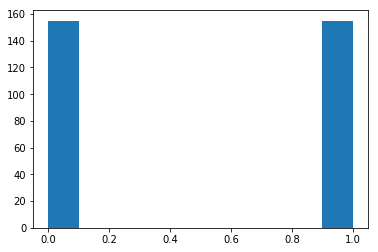

In [16]:
# This is the label for a val data
plt.hist(data.val_y)

In [17]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['A380', 'B747']

In [18]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape  # = (nombre de prediction , nombre de classe)

(310, 2)

In [19]:
#log_preds[:10]

In [20]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [21]:
# Récupère aléatoirement des prédictions
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 8), replace=False)

# Récupère les prédictions correctes
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

# Affiche les images
def plots(ims, figsize=(20,10), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

# Charge l'image
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

# Affiche des images avec un titre
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [(str(probs[x]) + "\n" + str(data.val_ds.fnames[x][10:][:20])) for x in idxs]
    print(title)
    return plots(imgs, rows=2, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

# Recupère les prédiction triées
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:8]] # Les 32 premiers éléments

# Recupère les prédictions les plus justes
def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most incorrect A380


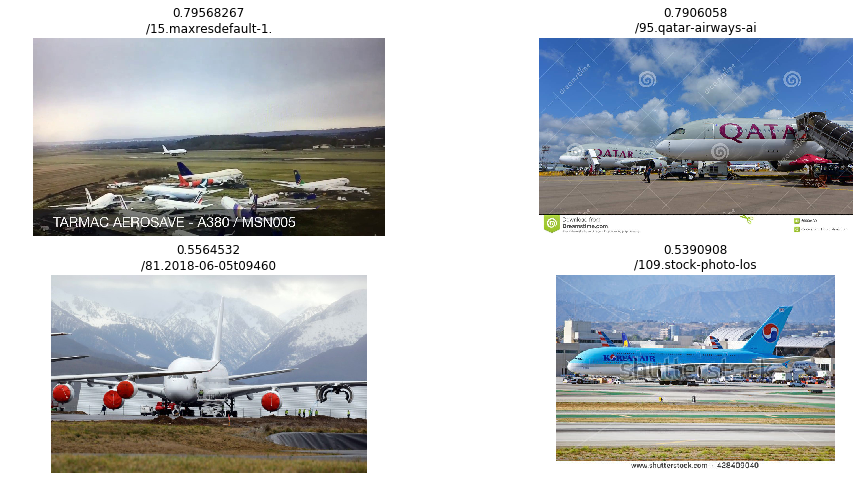

In [22]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect " + data.classes[0])

Most incorrect B747


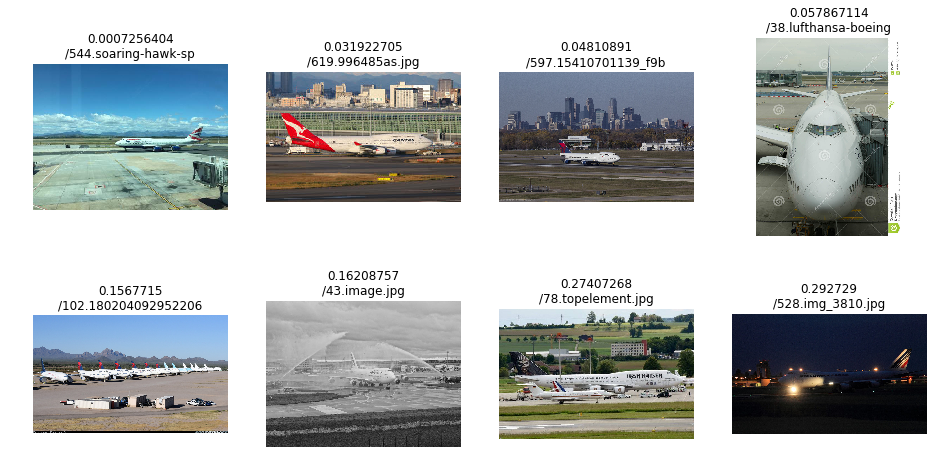

In [23]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect " + data.classes[1])

Most uncertain predictions


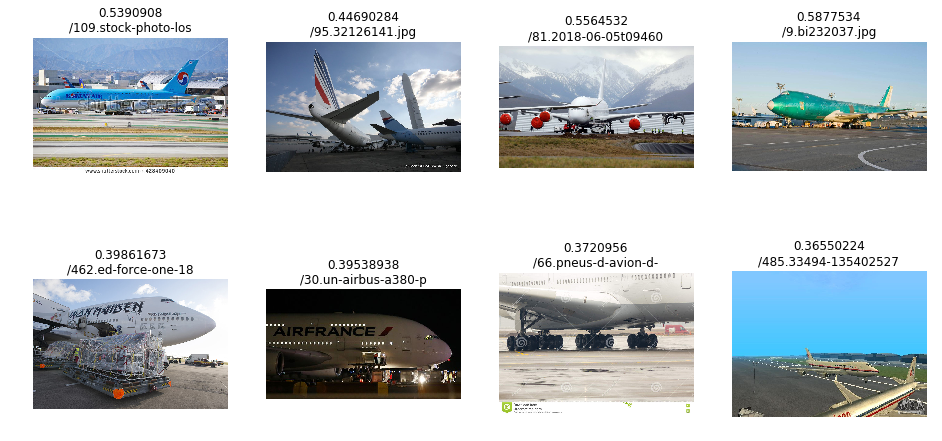

In [24]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:8]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

Most correct B747


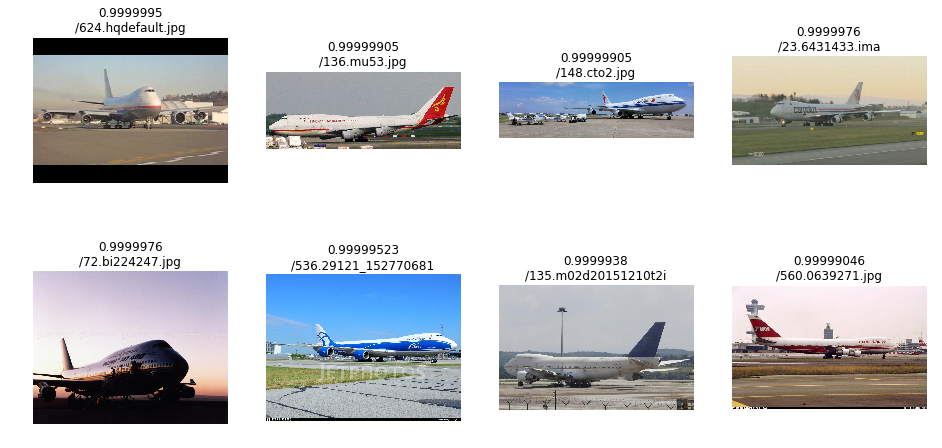

In [25]:
plot_val_with_title(most_by_correct(1, True), "Most correct " + data.classes[1])

Most correct A380


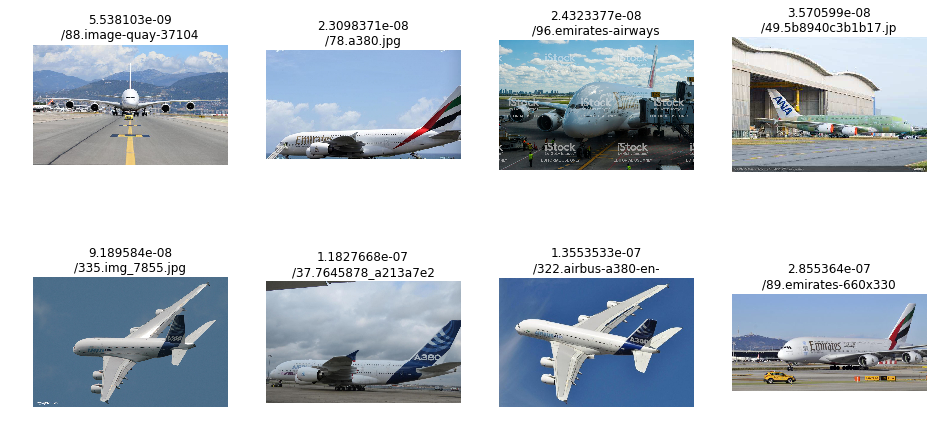

In [26]:
plot_val_with_title(most_by_correct(0, True), "Most correct " + data.classes[0])
# 1. A few correct labels at random
#plot_val_with_title(rand_by_correct(True), "Correctly classified")
# 2. A few incorrect labels at random
#plot_val_with_title(rand_by_correct(False), "Incorrectly classified")